## Imports and Setup

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import sklearn
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
#import seaborn as sns
%aimport mfc_video_utils
from mfc_video_utils import MfcVideoProcessor, BasicTransformer, compute_roc, save_object, load_object, grid_search_forest, grid_search_svm

pd.options.display.max_columns = 500
pd.options.display.max_rows = 2000
#sns.set(rc={"figure.figsize": (12, 8)})
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
from fastai.tabular import * 

## Load data

In [3]:
# datasets = [nc2017_dev, mfc18_dev1, mfc18_dev2, mfc18_eval, mfc18_gan, mfc19_val]
if os.path.isfile("datasets.pkl"):
    nc2017_dev, mfc18_dev1, mfc18_dev2, mfc18_eval, mfc18_gan, mfc19_val = load_object("datasets.pkl")
else:
    nc2017_dev = MfcVideoProcessor("nc2017_dev", datasets_location / "NC2017_Dev_Ver1", ref_avail=True)     ## nc2017 - dev (training)
    mfc18_dev1 = MfcVideoProcessor("mfc18_dev1", datasets_location / "MFC18_Dev1_Video_Ver2", ref_avail=True) ## mfc18 - dev1 (training)
    mfc18_dev2 = MfcVideoProcessor("mfc18_dev2",  datasets_location / "MFC18_Dev2_Video_Ver3", ref_avail=True) ## mfc18 - dev2 (training)
    mfc18_eval = MfcVideoProcessor("mfc18_eval", datasets_location / "MFC18_EvalPart1_Video_Ver1", ref_avail=True, ref_folder=True) ## mfc18 - eval (training?)
    mfc18_gan = MfcVideoProcessor("mfc18_gan", datasets_location / "MFC18_Eval_GAN_Video_Ver3", ref_avail=True, ref_folder=True) # mfc18 - gan (training?)
    mfc19_val = MfcVideoProcessor("mfc19_val", datasets_location /  "MFC19_Video_Validation_Ver1", ref_avail=True) # mfc19 - val (test)
    datasets = [nc2017_dev, mfc18_dev1, mfc18_dev2, mfc18_eval, mfc18_gan, mfc19_val]
    save_object(datasets, "datasets.pkl")    

#### Experiment Results

#### Fair + GAN setup
1. Train: NC2017_DEV + MFC18_DEV1 + MFC18_DEV2 + MFC18_GAN => Splits and select best
2. Test: MFC18_EVAL + MFC19_EVAL

##### Conclusions:
Our performance in MFC18_GAN is obviously better but we lose performance in MFC18_EVAL + MFC19_EVAL

In [4]:
train_vids = pd.concat([nc2017_dev.ffprobe_df, mfc18_dev1.ffprobe_df, mfc18_dev2.ffprobe_df, mfc18_gan.ffprobe_df], sort=False)
train_labels = nc2017_dev.labels + mfc18_dev1.labels + mfc18_dev2.labels + mfc18_gan.labels
test_vids = pd.concat([mfc18_eval.ffprobe_df, mfc19_val.ffprobe_df], sort=False)
test_labels = mfc18_eval.labels + mfc19_val.labels

In [5]:
train_vids['manipulated'] = ['Yes' if i==1 else 'No' for i in train_labels]

In [6]:
_columns = train_vids.columns.values
_dtypes = train_vids.dtypes.values
_kinds = np.array([dt.kind for dt in train_vids.dtypes])
_column_dtypes = {}
is_cat = _kinds == 'O'
_column_dtypes['cat'] = _columns[is_cat]
_column_dtypes['num'] = _columns[~is_cat]
_feature_names = _column_dtypes['num']

In [7]:
cat_names = _columns[is_cat].tolist()

In [8]:
train_vids = train_vids.sample(frac=1).reset_index(drop=True)

In [9]:
valid_idx = range(len(train_vids)-77, len(train_vids))

In [10]:
dep_var = 'manipulated'

In [28]:
procs = [FillMissing, Categorify, Normalize]

In [12]:
path = Path('./test')

In [29]:
data = TabularDataBunch.from_df(path, train_vids, dep_var, valid_idx=valid_idx, cat_names=cat_names, procs=procs)

In [30]:
(cat_x,cont_x),y = next(iter(data.train_dl))
for o in (cat_x, cont_x, y): print(to_np(o[5:11]))

[[1 1 3 1 ... 2 2 2 2]
 [1 1 1 1 ... 2 1 1 2]
 [1 1 1 1 ... 2 1 1 2]
 [1 1 3 1 ... 2 1 1 2]
 [1 1 3 1 ... 2 1 1 2]
 [1 1 3 1 ... 2 1 1 2]]
[[ 0.        0.       -0.042101  0.       ...  0.       -0.377584 -0.241359  0.      ]
 [ 0.        0.       -0.042101  0.       ...  0.       -0.377584 -0.242493  0.      ]
 [ 0.        0.       -0.042101  0.       ...  0.       -0.377584 -0.241189  0.      ]
 [ 0.        0.       -0.042101  0.       ...  0.       -0.377584 -0.242391  0.      ]
 [ 0.        0.       -0.042101  0.       ...  0.       -0.377584 -0.241766  0.      ]
 [ 0.        0.       -0.042101  0.       ...  0.       -0.377584 -0.2405    0.      ]]
[0 0 0 0 1 1]


In [44]:
emb_szs = { i : 10000 for i in cat_names }

In [31]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)

In [106]:
import matplotlib.pyplot as plt
import matplotlib
sns.reset_defaults()
sns.reset_orig()

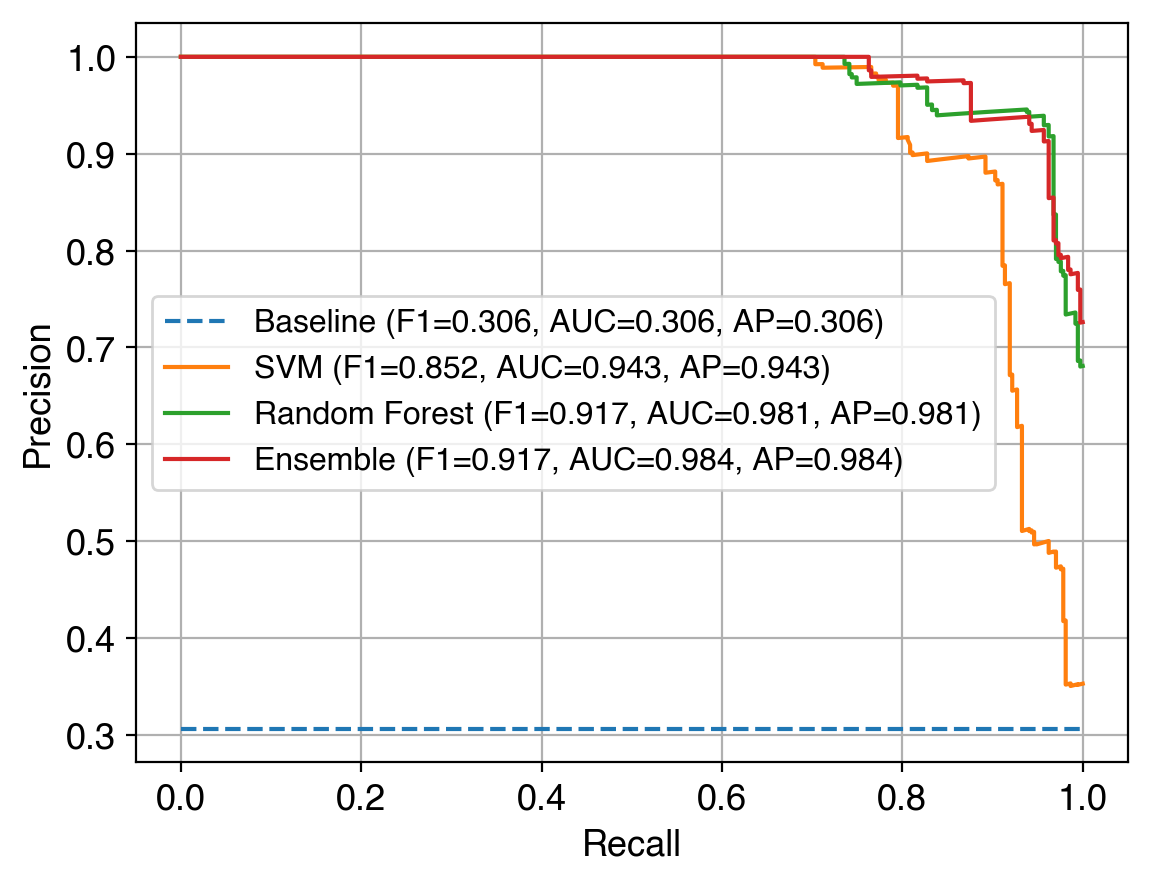

In [129]:
plt.rc('font', family='Helvetica', style='normal', weight='regular', size=13)

# plot no skill
plt.plot([0, 1], [0.306, 0.306], linestyle='--', label='Baseline' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (0.306, 0.306, 0.306))


## SVM
# predict probabilities
probs = gs_svm_10.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = gs_svm_10.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot SVM
plt.plot(recall, precision, label='SVM' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))

## Random Forest
# predict probabilities
probs = gs_forest_10.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = gs_forest_10.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot Random Forest
plt.plot(recall, precision, label='Random Forest' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))

## Ensemble
voting_10 = EnsembleVoteClassifier(clfs=[gs_forest_10.best_estimator_, gs_svm_10.best_estimator_], weights=[4,1], refit=False)
voting_10.fit(train_vids, train_labels)
# predict probabilities
probs = voting_10.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = voting_10.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot Ensemble
plt.plot(recall, precision, label='Ensemble' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))


# plot the precision-recall curve for the model

plt.xlabel('Recall', fontweight='regular')
plt.ylabel('Precision', fontweight='regular')
plt.legend(loc='best', fontsize=11.5)
plt.grid()

plt.savefig('results_10.pdf',bbox_inches='tight',format='pdf')
plt.show()

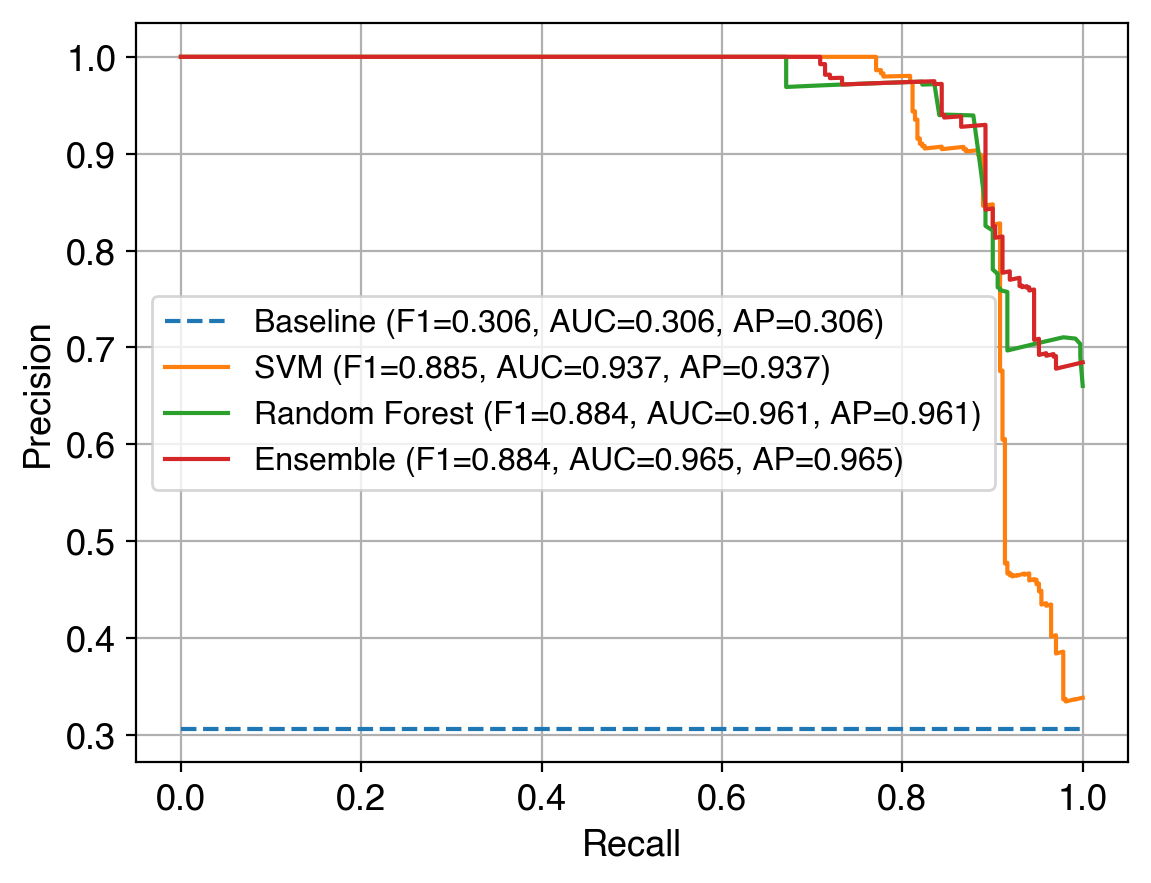

In [130]:
plt.rc('font', family='Helvetica', style='normal', weight='regular', size=13)

# plot no skill
plt.plot([0, 1], [0.306, 0.306], linestyle='--', label='Baseline' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (0.306, 0.306, 0.306))


## SVM
# predict probabilities
probs = gs_svm_25.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = gs_svm_25.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot SVM
plt.plot(recall, precision, label='SVM' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))

## Random Forest
# predict probabilities
probs = gs_forest_25.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = gs_forest_25.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot Random Forest
plt.plot(recall, precision, label='Random Forest' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))

## Ensemble
voting_25 = EnsembleVoteClassifier(clfs=[gs_forest_25.best_estimator_, gs_svm_25.best_estimator_], weights=[4,1], refit=False)
voting_25.fit(train_vids, train_labels)
# predict probabilities
probs = voting_25.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = voting_25.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot Ensemble
plt.plot(recall, precision, label='Ensemble' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))


# plot the precision-recall curve for the model

plt.xlabel('Recall', fontweight='regular')
plt.ylabel('Precision', fontweight='regular')
plt.legend(loc='best', fontsize=11.5)
plt.grid()


plt.savefig('results_25.pdf',bbox_inches='tight',format='pdf')
plt.show()

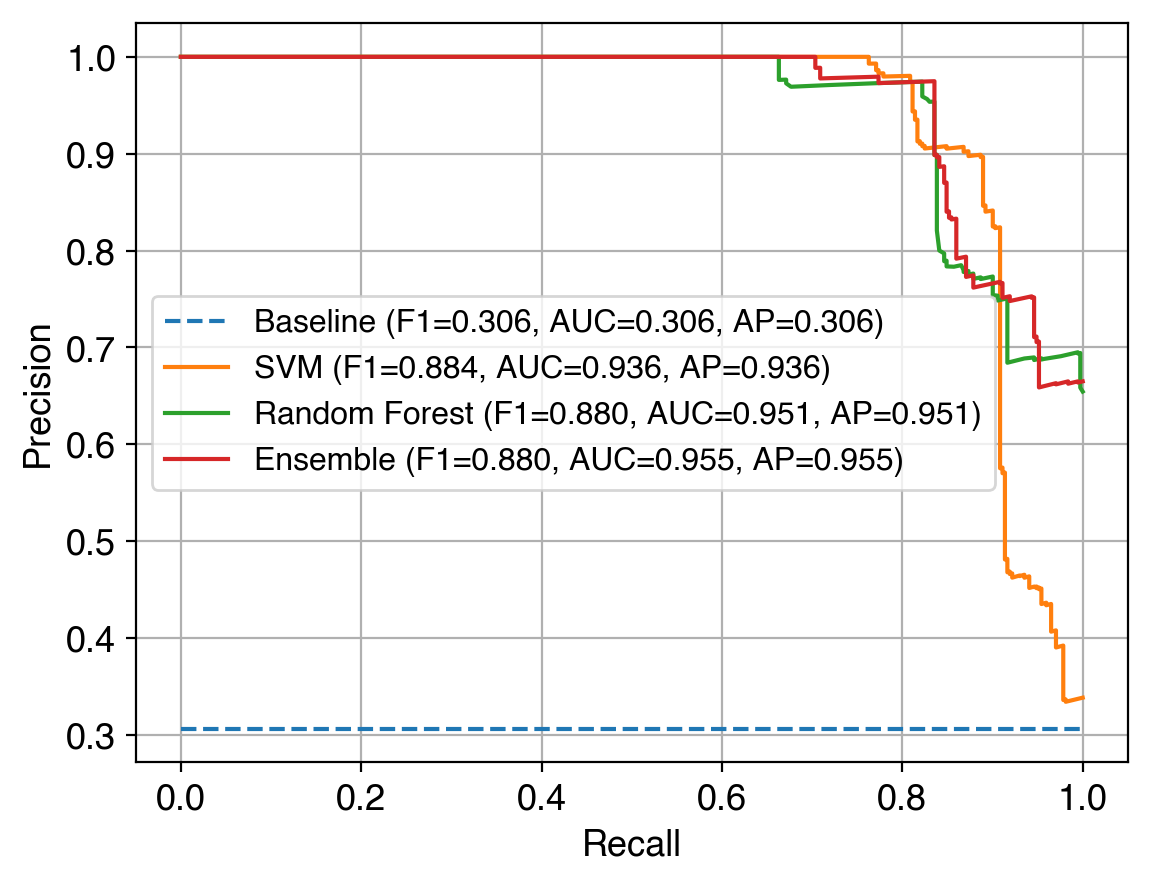

In [131]:
plt.rc('font', family='Helvetica', style='normal', weight='regular', size=13)


# plot no skill
plt.plot([0, 1], [0.306, 0.306], linestyle='--', label='Baseline' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (0.306, 0.306, 0.306))


## SVM
# predict probabilities
probs = gs_svm_50.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = gs_svm_50.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot SVM
plt.plot(recall, precision, label='SVM' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))

## Random Forest
# predict probabilities
probs = gs_forest_50.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = gs_forest_50.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot Random Forest
plt.plot(recall, precision, label='Random Forest' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))

## Ensemble
voting_50 = EnsembleVoteClassifier(clfs=[gs_forest_50.best_estimator_, gs_svm_50.best_estimator_], weights=[4,1], refit=False)
voting_50.fit(train_vids, train_labels)
# predict probabilities
probs = voting_50.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = voting_50.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot Ensemble
plt.plot(recall, precision, label='Ensemble' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))


# plot the precision-recall curve for the model

plt.xlabel('Recall', fontweight='regular')
plt.ylabel('Precision', fontweight='regular')
plt.legend(loc='best', fontsize=11.5)
plt.grid()


plt.savefig('results_50.pdf',bbox_inches='tight',format='pdf')
plt.show()

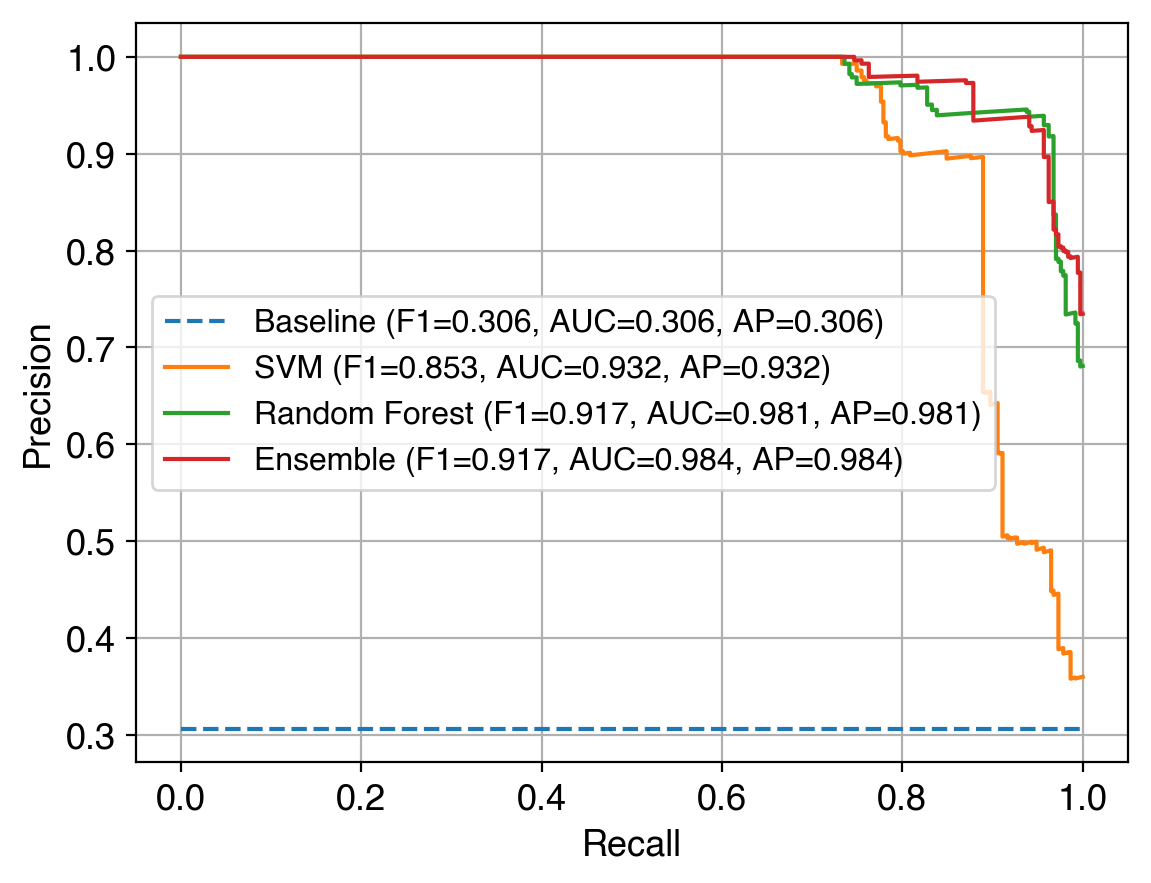

In [132]:
plt.rc('font', family='Helvetica', style='normal', weight='regular', size=13)

# plot no skill
plt.plot([0, 1], [0.306, 0.306], linestyle='--', label='Baseline' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (0.306, 0.306, 0.306))


## SVM
# predict probabilities
probs = gs_svm_75.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = gs_svm_75.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot SVM
plt.plot(recall, precision, label='SVM' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))

## Random Forest
# predict probabilities
probs = gs_forest_75.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = gs_forest_75.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot Random Forest
plt.plot(recall, precision, label='Random Forest' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))

## Ensemble
voting_75 = EnsembleVoteClassifier(clfs=[gs_forest_75.best_estimator_, gs_svm_75.best_estimator_], weights=[4,1], refit=False)
voting_75.fit(train_vids, train_labels)
# predict probabilities
probs = voting_75.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = voting_75.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot Ensemble
plt.plot(recall, precision, label='Ensemble' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))


# plot the precision-recall curve for the model

plt.xlabel('Recall', fontweight='regular')
plt.ylabel('Precision', fontweight='regular')
plt.legend(loc='center left', fontsize=11.5)
plt.grid()


plt.savefig('results_75.pdf',bbox_inches='tight',format='pdf')
plt.show()

In [98]:
svm_icml = [gs_svm_10.best_estimator_, gs_svm_25.best_estimator_, gs_svm_50.best_estimator_, gs_svm_75.best_estimator_]
forest_icml = [gs_forest_10, gs_forest_25, gs_forest_50, gs_forest_75]
voting_icml = [voting_10, voting_25, voting_50, voting_75]

save_object(svm_icml, 'list_svm_icml.pkl')
save_object(forest_icml, 'list_forest_icml.pkl')
save_object(voting_icml, 'list_voting_icml.pkl')

PicklingError: Can't pickle <class 'mfc_video_utils.BasicTransformer'>: it's not the same object as mfc_video_utils.BasicTransformer